#### MODELLING 

In this modelling section we will use Alzheimer's dataset which consists of MRI images belonging to 4 classes;

MildDemented
ModerateDemented
NonDemented
VeryMildDemented
The images are from people who already have the Alzheimer's disease.

The dataset is split into 2 directories, one for train data and the other for test data.

Based on the article from this site, it has been noted that there are some discrepancies between the test and train images from the Kaggle MRI dataset. Due to this discrepancy, the models tend to perform very well on the train dataset but when it comes to evaluating the model on the test dataset, the model performs very poorly and always seems to overfit.

In order to avoid such kind of problem, we will combine the entire train and test dataset into one and convert the images into arrays. We will then shuffle the images and split them again into train, validation and test data.

#### LOADING NECESSARY PACKAGES

In [5]:
import os
import glob
import pandas as pd
import tensorflow as tf
from collections import Counter
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array
from sklearn.utils import shuffle
import tensorflow as tf
import keras
from keras import layers
from keras.layers import ZeroPadding2D,LeakyReLU
from keras import models
from keras import optimizers
from keras.models import Model, load_model
from tqdm import tqdm
from PIL import Image
import cv2
from tensorflow.keras.applications import VGG16, VGG19, DenseNet201
from tensorflow.keras.applications import EfficientNetB0
from keras.wrappers.scikit_learn import KerasRegressor
from keras.metrics import BinaryAccuracy, Precision, Recall, AUC
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import cross_val_predict
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
!pip install keras-tuner --upgrade
import keras_tuner
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import pickle
import joblib

from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(2)

In [6]:
# Loading the train images
labels = ["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]

# function to load and combine all the train images
def get_images(path = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset", 
               class_labels = labels):
    
    X_train = []
    y_train = []
    image_size = 150
    
    # getting the train images
    for i in class_labels:
        folderPath = os.path.join(path,'train',i)
        for j in tqdm(os.listdir(folderPath)):
            img = cv2.imread(os.path.join(folderPath,j))
            img = cv2.resize(img,(image_size, image_size))
            X_train.append(img)
            y_train.append(i)
    
    # getting the test images
    for i in class_labels:
        folderPath = os.path.join(path,'test',i)
        for j in tqdm(os.listdir(folderPath)):
            img = cv2.imread(os.path.join(folderPath,j))
            img = cv2.resize(img,(image_size,image_size))
            X_train.append(img)
            y_train.append(i)
            
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    # shuffle all the images
    X_train, y_train = shuffle(X_train, y_train, random_state = 42)
    return X_train, y_train

# get images
X_train, y_train = get_images()
X_train.shape, y_train.shape

100%|██████████| 448/448 [00:02<00:00, 193.41it/s]


((6400, 150, 150, 3), (6400,))

After combining and shuffling all the images, we will now split them into train, validation and test datasets.

In [7]:
# spliting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2,random_state = 42)

# splitting train data to get validation data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 42)

# check shape of data
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((4608, 150, 150, 3),
 (4608,),
 (1280, 150, 150, 3),
 (1280,),
 (512, 150, 150, 3),
 (512,))

#### Exploring the images

In [8]:
class ImageClassPreview:
    def __init__(self, X_train, y_train, labels):
        self.X_train = X_train
        self.y_train = y_train
        self.labels = labels

    def preview_images(self):
        k=0
        fig, ax = plt.subplots(1,4,figsize=(20,20))
        fig.text(s = "Sample Image From Each Class", size = 18, fontweight = "bold",
                     fontname = "monospace", color = "#313131", y = 0.62, x = 0.4, alpha = 0.8)
        for i in self.labels:
            j = 0
            while True :
                if self.y_train[j]==i:
                    ax[k].imshow(self.X_train[j])
                    ax[k].set_title(self.y_train[j])
                    ax[k].axis('off')
                    k+=1
                    break
                j+=1
    def hist_of_classes(self):
        plt.hist(self.y_train)



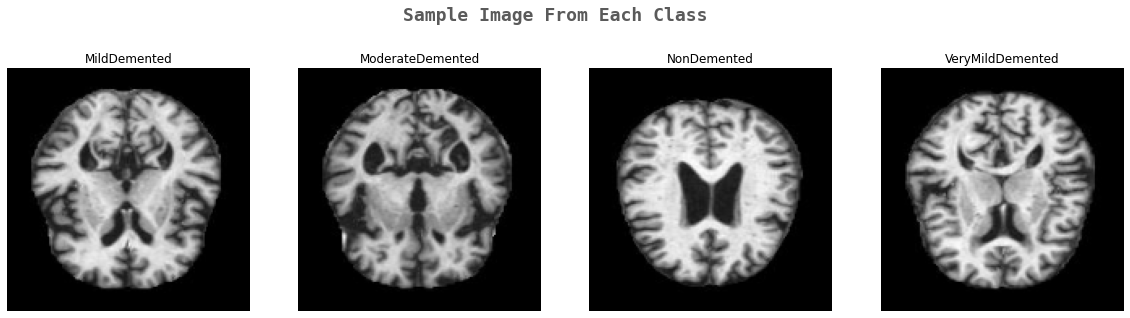

In [9]:
# Preview of an image from each class
class_preview = ImageClassPreview(X_train, y_train, labels)
class_preview.preview_images()



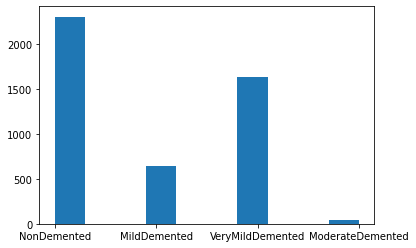

In [10]:
# Visualizing the number of images in each class
class_preview.hist_of_classes()

From the histogram above our dataset is imbalanced with the nondemented having the highest number and moderate demented the least.

#### Data Preprocessing

In this phase we will solve the class imbalance using smote,change the image labels into numerical values and scale our images as our data normalization step to ensure that each input parameter (pixel, in this case) has a similar data distribution. This makes convergence faster while training the network. 

In [11]:
# one hot encoding the train classes for modelling
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

# one hot encoding the test classes for modelling
y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

# one hot encoding the val classes for modelling
y_val_new = []
for i in y_val:
    y_val_new.append(labels.index(i))
y_val = y_val_new
y_val = tf.keras.utils.to_categorical(y_val)
    

In [12]:
# scaling the train images 
def scale_images(images):
    images = images.astype('float32')
    images /= 255
    return images

X_train = scale_images(X_train)
X_val = scale_images(X_val)
X_test = scale_images(X_test)


In [13]:
# SMOTE to solve class imbalance
sm = SMOTE(random_state = 42)
X_train, y_train = sm.fit_resample(X_train.reshape(-1, 150 * 150 * 3), y_train)
X_train = X_train.reshape(-1, 150, 150, 3)

# check shape of data after oversampling
X_train.shape, y_train.shape

((9204, 150, 150, 3), (9204, 4))

After using SMOTE, the number of images have increased because SMOTE creates more synthetic data which is used to solve the class imbalance.

We will create some functions for evaluating the performance of our models

In [14]:
# function to evaluate model

def evaluate_model(model):
    print("train_results")
    (model.evaluate(X_train, y_train))
    print("validation_results")
    print(model.evaluate(X_val, y_val))
    
# function to plot model's performance
def plot_accuracy_loss(model):
    scores = model.history

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(scores["recall"], label='Training Recall Score')
    ax1.plot(scores["val_recall"], label='Validation Recall Score')
    ax1.set_title('Recall')
    ax1.legend(loc='lower right')
    ax1.set_ylabel('Recall')
    ax1.set_xlabel('Epoch')

    ax2.plot(scores["loss"], label='Training loss')
    ax2.plot(scores["val_loss"], label='Validation loss')
    ax2.set_title('Loss')
    ax2.legend(loc='upper right')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('Epoch')
    plt.show()

Given that it is computationally expensive to run all given epochs for all our models we will establish callbacks which will stop the model once the recall stops improving.

In [15]:
# We use callbacks to minimize on computational costs

callback = keras.callbacks.EarlyStopping(monitor = 'val_recall',
                                          patience = 3,
                                          restore_best_weights = True)


### MODELLING

#### BASELINE MODEL (ANN)

For our baseline model we will build a simple artificial neural network model with only 2 hidden layers and an input and output layer.

In [16]:
def base_model():
    model = models.Sequential()
    
    # input layer
    model.add(layers.Flatten(input_shape = (150, 150, 3)))
    
    # hidden layers
    model.add(layers.Dense(4, activation = "relu"))
    model.add(layers.Dense(8, activation = "relu"))
    
    # output layer
    model.add(layers.Dense(4, activation = "softmax"))
    
    return model

base_model = base_model()

# compile model
base_model.compile(loss = "categorical_crossentropy", 
                   optimizer = "adam", 
                   metrics = ["Accuracy", "Precision", "Recall",
                             keras.metrics.AUC(name = "auc")])

# Fit the model
base_hist = base_model.fit(X_train,
                           y_train,
                           epochs = 20,
                           validation_data = (X_val, y_val),
                           callbacks=callback
                           )

2023-01-15 19:36:55.758257: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 19:36:55.845240: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 19:36:55.846034: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 19:36:55.848218: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/20
288/288 [==============================] - 5s 10ms/step - loss: 1.3998 - Accuracy: 0.2419 - precision: 0.1875 - recall: 0.0013 - auc: 0.4913 - val_loss: 1.3856 - val_Accuracy: 0.3242 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 2/20
288/288 [==============================] - 2s 8ms/step - loss: 1.3864 - Accuracy: 0.2420 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4955 - val_loss: 1.3861 - val_Accuracy: 0.3242 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 3/20
288/288 [==============================] - 3s 10ms/step - loss: 1.3865 - Accuracy: 0.2444 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4956 - val_loss: 1.3865 - val_Accuracy: 0.0137 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3424
Epoch 4/20
288/288 [==============================] - 2s 8ms/step - loss: 1.3864 - Accuracy: 0.2439 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4972 - val_loss: 1.3900 - val_Accura

In [17]:
evaluate_model(base_model)

train_results


2023-01-15 19:37:37.310648: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2485080000 exceeds 10% of free system memory.
2023-01-15 19:37:40.086141: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2485080000 exceeds 10% of free system memory.


288/288 [==============================] - 3s 10ms/step - loss: 1.3863 - Accuracy: 0.2500 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000
validation_results
16/16 [==============================] - 0s 7ms/step - loss: 1.3856 - Accuracy: 0.3242 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000
[1.385640025138855, 0.32421875, 0.0, 0.0, 0.5]


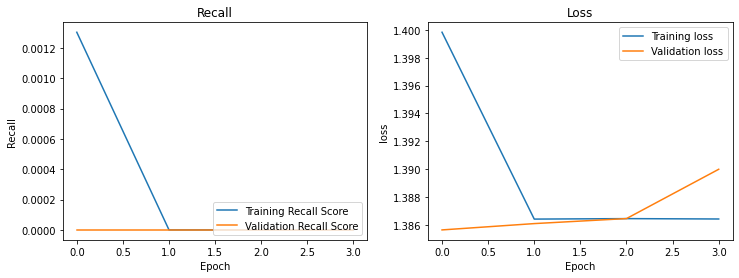

In [18]:
plot_accuracy_loss(base_hist)

Our basic ANN model is performing terribly hence we will try building a simple CNN model so as to achieve a 95% recall score.

#### FIRST MODEL

In [12]:
def model1():
    
    model = models.Sequential()

    # input layer
    model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)))

    # adding hidden layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))

    # output layer
    model.add(layers.Dense(4, activation='softmax'))
    
    return model

model1 = model1()

# compile the model
model1.compile(optimizer = "adam",
                   loss = "categorical_crossentropy",
                   metrics = ["Accuracy", "Precision", "Recall", keras.metrics.AUC(name = "auc")])

# fit model
model1_hist = model1.fit(X_train,
                         y_train,
                         steps_per_epoch = 8,
                         epochs = 20,
                         verbose = 1,
                         validation_data = (X_val, y_val)
                          )

2023-01-14 18:37:10.678753: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 18:37:10.763266: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 18:37:10.764103: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 18:37:10.766363: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/20


2023-01-14 18:37:20.727274: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


8/8 [==============================] - 16s 941ms/step - loss: 2.0973 - Accuracy: 0.2743 - precision: 0.2587 - recall: 0.0908 - auc: 0.5092 - val_loss: 1.3411 - val_Accuracy: 0.3242 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6176
Epoch 2/20
8/8 [==============================] - 4s 523ms/step - loss: 1.3531 - Accuracy: 0.3935 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6775 - val_loss: 1.3072 - val_Accuracy: 0.5078 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8074
Epoch 3/20
8/8 [==============================] - 4s 549ms/step - loss: 1.2520 - Accuracy: 0.5954 - precision: 1.0000 - recall: 0.0015 - auc: 0.8520 - val_loss: 1.2272 - val_Accuracy: 0.5156 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7965
Epoch 4/20
8/8 [==============================] - 4s 541ms/step - loss: 1.0147 - Accuracy: 0.6268 - precision: 0.9793 - recall: 0.2008 - auc: 0.8726 - val_loss: 1.0267 - val_Accuracy: 0.4707 - val_precision: 0.6957 -

In [13]:
evaluate_model(model1)

train_results


2023-01-14 18:46:19.339086: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2485080000 exceeds 10% of free system memory.
2023-01-14 18:46:22.268375: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2485080000 exceeds 10% of free system memory.


288/288 [==============================] - 3s 10ms/step - loss: 0.0835 - Accuracy: 0.9796 - precision: 0.9808 - recall: 0.9779 - auc: 0.9992
validation_results
16/16 [==============================] - 0s 9ms/step - loss: 0.2824 - Accuracy: 0.8730 - precision: 0.8780 - recall: 0.8711 - auc: 0.9854
[0.28240305185317993, 0.873046875, 0.8779527544975281, 0.87109375, 0.9853909015655518]


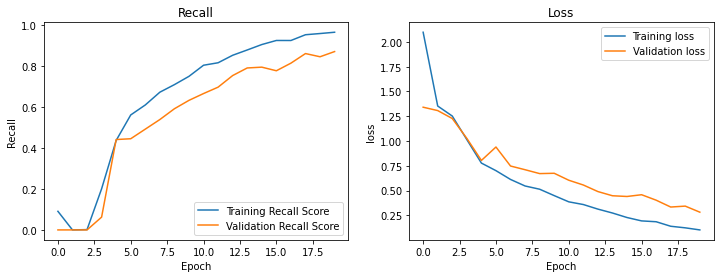

In [17]:
plot_accuracy_loss(model1_hist)

Not the best model yet but this simple cnn model is performing better than our baseline model with the ANN architecture. The validation recall score improve from approximately zero to 87%.However compared to the train our model is performing very well on the train but not quite so well on the validation. Therefore to prevent overfitting we will batch normalization,zero padding and droupout layers to our cnn architecture and see whether we get better results.

In [12]:
def model2():
    model = models.Sequential()

    # Add zero padding of size (1,1) before the first convolutional layer
    model.add(ZeroPadding2D(padding=(1, 1)))

    #Convolution layers
    model.add(layers.Conv2D(32, (3, 3), input_shape = (150,150, 3), activation = 'ReLU', data_format='channels_last'))
    model.add(ZeroPadding2D(padding=(1, 1)))
    model.add(layers.MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
    model.add(layers.BatchNormalization(axis = -1))
    model.add(layers.Dropout(0.2))

    model.add(ZeroPadding2D(padding=(1, 1)))
    model.add(layers.Conv2D(64, (3, 3), activation = 'PReLU'))
    model.add(ZeroPadding2D(padding=(1, 1)))
    model.add(layers.MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
    model.add(layers.BatchNormalization(axis = -1))
    model.add(layers.Dropout(0.2))

    model.add(ZeroPadding2D(padding=(1, 1)))
    model.add(layers.Conv2D(128, (3, 3), activation = 'ReLU'))
    model.add(ZeroPadding2D(padding=(1, 1)))
    model.add(layers.MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
    model.add(layers.BatchNormalization(axis = -1))
    model.add(layers.Dropout(0.2))

    # Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(activation = 'elu', units=512))
    model.add(layers.BatchNormalization(axis = -1))
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(activation = 'selu', units=256))
    model.add(layers.BatchNormalization(axis = -1))
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(activation = 'ReLU', units=128))
    model.add(layers.BatchNormalization(axis = -1))
    model.add(layers.Dropout(0.2))
    
    # Output layer
    model.add(layers.Dense(activation = 'softmax', units=4))

    
    return model
model2 = model2()

# Compile model
model2.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics =  ["Accuracy", "Precision", "Recall", keras.metrics.AUC(name = "auc")])

#fit model
model2_hist = model2.fit(X_train,
         y_train,
         epochs = 20,
         validation_data = (X_val, y_val))


2023-01-15 10:01:04.232468: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 10:01:04.321035: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 10:01:04.321805: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 10:01:04.323938: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/20


2023-01-15 10:01:14.497651: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


288/288 [==============================] - 18s 34ms/step - loss: 0.7238 - Accuracy: 0.7002 - precision: 0.7415 - recall: 0.6540 - auc: 0.9137 - val_loss: 1.3758 - val_Accuracy: 0.3789 - val_precision: 0.3789 - val_recall: 0.3789 - val_auc: 0.7598
Epoch 2/20
288/288 [==============================] - 9s 31ms/step - loss: 0.3240 - Accuracy: 0.8669 - precision: 0.8825 - recall: 0.8517 - auc: 0.9807 - val_loss: 0.5961 - val_Accuracy: 0.7363 - val_precision: 0.7470 - val_recall: 0.7324 - val_auc: 0.9339
Epoch 3/20
288/288 [==============================] - 9s 30ms/step - loss: 0.1798 - Accuracy: 0.9301 - precision: 0.9362 - recall: 0.9252 - auc: 0.9939 - val_loss: 0.1903 - val_Accuracy: 0.9297 - val_precision: 0.9314 - val_recall: 0.9277 - val_auc: 0.9931
Epoch 4/20
288/288 [==============================] - 9s 30ms/step - loss: 0.1172 - Accuracy: 0.9588 - precision: 0.9616 - recall: 0.9548 - auc: 0.9971 - val_loss: 0.1808 - val_Accuracy: 0.9355 - val_precision: 0.9373 - val_recall: 0.9336 

In [13]:
evaluate_model(model2)

train_results


2023-01-15 10:04:35.596924: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2485080000 exceeds 10% of free system memory.
2023-01-15 10:04:38.414630: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2485080000 exceeds 10% of free system memory.


288/288 [==============================] - 4s 13ms/step - loss: 0.0077 - Accuracy: 0.9977 - precision: 0.9977 - recall: 0.9975 - auc: 1.0000
validation_results
16/16 [==============================] - 0s 12ms/step - loss: 0.0522 - Accuracy: 0.9824 - precision: 0.9863 - recall: 0.9824 - auc: 0.9994
[0.05219140276312828, 0.982421875, 0.9862744808197021, 0.982421875, 0.9994462728500366]


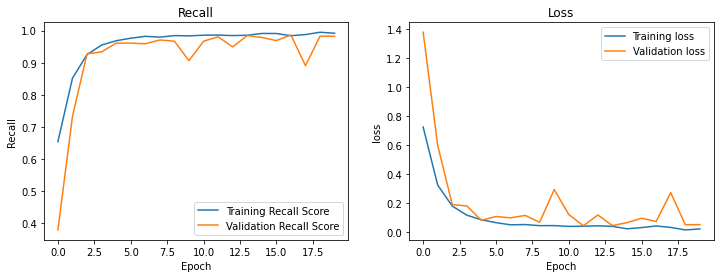

In [14]:
plot_accuracy_loss(model2_hist)

From the graph as the number of epochs increase recall increases and loss decreases up till the 4 epoch.We have a recall score of 98% on the validation data and 99% on the train. Our model has improved and most importantly it is not overfitting.This result are amazing but lets run a random search may be we may get 100%

In [24]:
def find_best_model(hp):
    model = keras.Sequential([
    keras.layers.ZeroPadding2D(padding=(1, 1)),
    keras.layers.Conv2D(
        filters=hp.Int("conv_1_filter", min_value=16, max_value=32, step=16),
        kernel_size=hp.Choice("conv_1_kernel", values = [3,5]),
        activation=hp.Choice("conv_1_activation", values=["ReLU", "PReLU","selu", "elu"]),
        input_shape=(150,150,3)
        ),
    keras.layers.MaxPooling2D(pool_size=(2, 2), data_format="channels_last"),
    keras.layers.BatchNormalization(axis=-1),
    keras.layers.Dropout(hp.Choice("conv_1_dropout", values=[0.2, 0.4, 0.6])),
    
    keras.layers.ZeroPadding2D(padding=(1, 1)),
    keras.layers.Conv2D(
            filters=hp.Int("conv_2_filter", min_value=16, max_value=64, step=16),
            kernel_size=hp.Choice("conv_2_kernel", values = [3,5]),
            activation=hp.Choice("conv_2_activation", values=["ReLU", "PReLU","selu", "elu"]),
        ),
    keras.layers.MaxPooling2D(pool_size=(2, 2), data_format="channels_last"),
    keras.layers.BatchNormalization(axis=-1),
    keras.layers.Dropout(hp.Choice("conv_2_dropout", values=[0.2, 0.4, 0.6])),
        
    keras.layers.ZeroPadding2D(padding=(1, 1)),
    keras.layers.Conv2D(
            filters=hp.Int("conv_3_filter", min_value=16, max_value=128, step=16),
            kernel_size=hp.Choice("conv_3_kernel", values = [3,5]),
            activation=hp.Choice("conv_3_activation", values=["ReLU", "PReLU","selu" ,"elu"]),
        ),
    keras.layers.MaxPooling2D(pool_size=(2, 2), data_format="channels_last"),
    keras.layers.BatchNormalization(axis=-1),
    keras.layers.Dropout(hp.Choice("conv_3_dropout",values=[0.2, 0.4, 0.6])),
        
    keras.layers.Flatten(),
    keras.layers.Dense(
            units=hp.Int("dense_1_units", min_value=32, max_value=128, step=16),
            activation=hp.Choice("dense_1_activation", values=["ReLU", "PReLU","selu", "elu"])
    ),
    keras.layers.BatchNormalization(axis=-1),
    keras.layers.Dropout(hp.Choice("dense_1_dropout", values=[0.2, 0.4, 0.6])),

    keras.layers.Dense(
            units=hp.Int("dense_2_units", min_value=32, max_value=128, step=16),
            activation=hp.Choice("dense_2_activation", values=["ReLU", "PReLU","selu", "elu"])
    ),
    keras.layers.BatchNormalization(axis=-1),
    keras.layers.Dropout(hp.Choice("dense_2_dropout", values=[0.2, 0.4, 0.6])),
    
    keras.layers.Dense(4, activation="softmax")
])
    model.compile(optimizer = tf.keras.optimizers.Adam(hp.Choice("learning_rate", 
                                                                  values=[1e-2, 1e-3])),
                      loss='categorical_crossentropy',
                      metrics = ["Accuracy", "Precision", "Recall"])
    return model
    
# implement function and use random search
tuner_search = RandomSearch(find_best_model,
                            keras_tuner.Objective("val_recall", direction="max"),
                            max_trials = 10
                            )
tuner_search.search(X_train, y_train, epochs = 20, batch_size = 32, validation_data = (X_val, y_val),callbacks = [callback])
    



Trial 10 Complete [00h 00m 37s]
val_recall: 0.35546875

Best val_recall So Far: 0.794921875
Total elapsed time: 00h 06m 17s


From the random search the best recall score is 79% which is lower than our modified CNN model.

#### TRANSFER LEARNING

For image classification,transfer learning is known to perform best.Transfer learning involves the use of pre-trained models instead of training a neural network from scratch. The pretrained models serve as a starting point for training. The transfer learning models we will use are;

- VGG16
- VGG19
- EfficientNetB0
- DenseNet

In [12]:
# function to implement the transfer learning models.
def transfer_model(model):
    model = model(input_shape = (150, 150, 3), weights = "imagenet", include_top = False)
    
    # ensuring the model is not trained again
    for layer in model.layers:
        layer.trainable = False
        
    # adding a dense layer at the bottom 
    X = layers.Flatten()(model.output)
    X = layers.Dense(units = 4, activation = "softmax")(X)
    model = Model(model.input, X)
    
    return model

#### VGG16

In [13]:
# load vgg16 model
vgg16 = transfer_model(VGG16)

# compile model
vgg16.compile(optimizer = "adam",
               loss = "categorical_crossentropy",
               metrics = ["Accuracy", "Precision", "Recall", keras.metrics.AUC(name = "auc")])

# fit model
vgg16_hist = vgg16.fit(X_train,
                      y_train,
                      steps_per_epoch = 8,
                      epochs = 30,
                      verbose = 1,
                       batch_size = 32,
                      validation_data = (X_val, y_val),
                       callbacks = callback
                      )

2023-01-14 20:11:06.385005: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 20:11:06.490173: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 20:11:06.491400: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 20:11:06.493702: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step


2023-01-14 20:11:09.557837: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2485080000 exceeds 10% of free system memory.
2023-01-14 20:11:12.310625: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2485080000 exceeds 10% of free system memory.
2023-01-14 20:11:14.271008: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2023-01-14 20:11:16.222415: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


8/8 [==============================] - 10s 227ms/step - loss: 1.5111 - Accuracy: 0.2695 - precision: 0.3404 - recall: 0.0625 - auc: 0.5319 - val_loss: 2.0690 - val_Accuracy: 0.1270 - val_precision: 0.1406 - val_recall: 0.0703 - val_auc: 0.3034
Epoch 2/30
8/8 [==============================] - 1s 121ms/step - loss: 1.3506 - Accuracy: 0.3828 - precision: 0.5102 - recall: 0.0977 - auc: 0.6298 - val_loss: 1.1494 - val_Accuracy: 0.3945 - val_precision: 0.4651 - val_recall: 0.0391 - val_auc: 0.7546
Epoch 3/30
8/8 [==============================] - 1s 120ms/step - loss: 1.1778 - Accuracy: 0.4844 - precision: 0.9200 - recall: 0.0898 - auc: 0.7561 - val_loss: 1.2649 - val_Accuracy: 0.4375 - val_precision: 0.7586 - val_recall: 0.0859 - val_auc: 0.6731
Epoch 4/30
8/8 [==============================] - 1s 117ms/step - loss: 1.0848 - Accuracy: 0.5938 - precision: 0.8444 - recall: 0.1484 - auc: 0.8281 - val_loss: 1.2549 - val_Accuracy: 0.4316 - val_precision: 0.7143 - val_recall: 0.0684 - val_auc: 0

In [14]:
evaluate_model(vgg16)

train_results


2023-01-14 20:11:38.560564: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2485080000 exceeds 10% of free system memory.
2023-01-14 20:11:56.257414: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2485080000 exceeds 10% of free system memory.


288/288 [==============================] - 12s 41ms/step - loss: 1.2451 - Accuracy: 0.3494 - precision: 0.4930 - recall: 0.0342 - auc: 0.6933
validation_results
16/16 [==============================] - 1s 36ms/step - loss: 1.1494 - Accuracy: 0.3945 - precision: 0.4651 - recall: 0.0391 - auc: 0.7546
[1.1493576765060425, 0.39453125, 0.4651162922382355, 0.0390625, 0.7546424865722656]


The model had a recall score of 20% down from our prevvious 79% from the random search.

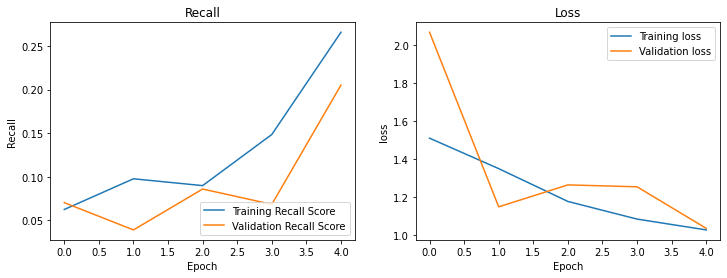

In [15]:
plot_accuracy_loss(vgg16_hist)

The recall increases in the first few epochs then steadily rises and falls. The loss is the vice versa it increases then starts to fall and rise interchangebly.

#### VGG19

In [13]:
# preview summary
vgg19 = transfer_model(VGG19)

# compile model
vgg19.compile(optimizer = "adam",
               loss = "categorical_crossentropy",
               metrics = ["Accuracy", "Precision", "Recall", keras.metrics.AUC(name = "auc")])

# fit model
vgg19_hist = vgg19.fit(X_train,
                      y_train,
                      steps_per_epoch = 8,
                      epochs = 30,
                      verbose = 1,
                       batch_size = 32,
                      validation_data = (X_val, y_val),callbacks=callback)



2023-01-14 20:29:43.688611: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 20:29:43.787322: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 20:29:43.788114: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 20:29:43.789895: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

80150528/80134624 [==============================] - 1s 0us/step


2023-01-14 20:29:47.171891: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2485080000 exceeds 10% of free system memory.
2023-01-14 20:29:49.924835: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2485080000 exceeds 10% of free system memory.
2023-01-14 20:29:51.967719: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2023-01-14 20:29:54.175391: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


8/8 [==============================] - 11s 256ms/step - loss: 1.5703 - Accuracy: 0.2695 - precision: 0.3623 - recall: 0.0977 - auc: 0.5299 - val_loss: 2.0325 - val_Accuracy: 0.1152 - val_precision: 0.1511 - val_recall: 0.0820 - val_auc: 0.3201
Epoch 2/30
8/8 [==============================] - 1s 151ms/step - loss: 1.4298 - Accuracy: 0.3008 - precision: 0.3367 - recall: 0.1289 - auc: 0.5993 - val_loss: 1.2269 - val_Accuracy: 0.4375 - val_precision: 0.5303 - val_recall: 0.0684 - val_auc: 0.7220
Epoch 3/30
8/8 [==============================] - 1s 141ms/step - loss: 1.2166 - Accuracy: 0.4609 - precision: 0.5882 - recall: 0.0781 - auc: 0.7236 - val_loss: 1.3193 - val_Accuracy: 0.4297 - val_precision: 0.7857 - val_recall: 0.0859 - val_auc: 0.6385
Epoch 4/30
8/8 [==============================] - 1s 140ms/step - loss: 1.1361 - Accuracy: 0.5469 - precision: 0.8302 - recall: 0.1719 - auc: 0.7926 - val_loss: 1.2526 - val_Accuracy: 0.4316 - val_precision: 0.7619 - val_recall: 0.0625 - val_auc: 0

In [14]:
evaluate_model(vgg19)

train_results


2023-01-14 21:08:11.382688: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2485080000 exceeds 10% of free system memory.
2023-01-14 21:08:14.373865: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2485080000 exceeds 10% of free system memory.


288/288 [==============================] - 14s 46ms/step - loss: 1.0655 - Accuracy: 0.6111 - precision: 0.9396 - recall: 0.1742 - auc: 0.8371
validation_results
16/16 [==============================] - 1s 43ms/step - loss: 1.2526 - Accuracy: 0.4316 - precision: 0.7619 - recall: 0.0625 - auc: 0.6922
[1.2525933980941772, 0.431640625, 0.761904776096344, 0.0625, 0.6922416687011719]


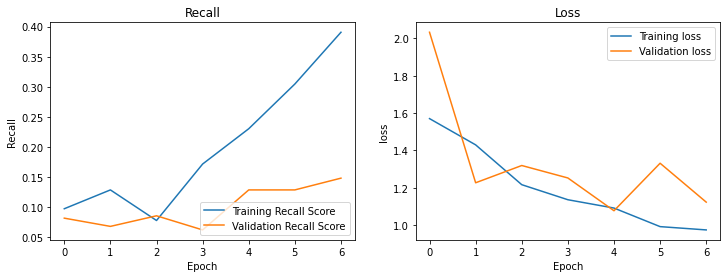

In [15]:
plot_accuracy_loss(vgg19_hist)

The performance of the VGG19 is even worse.It has 17% recall.

#### EfficientNetB0

In [15]:
# Instantiate efficientnet
efficientnet = transfer_model(EfficientNetB0)
# compile model
efficientnet.compile(optimizer = "adam",
               loss = "categorical_crossentropy",
               metrics = ["Accuracy", "Precision", "Recall", keras.metrics.AUC(name = "auc")])

# fit model
efficientnet_hist = efficientnet.fit(X_train,
                                      y_train,
                                      steps_per_epoch = 8,
                                      epochs = 30,
                                      verbose = 1,
                                      batch_size = 32,
                                      validation_data = (X_val, y_val),
                                     callbacks=callback
                                      )

2023-01-15 09:00:02.799784: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 09:00:02.896480: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 09:00:02.897243: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 09:00:02.898855: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

16719872/16705208 [==============================] - 0s 0us/step


2023-01-15 09:00:07.009791: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2485080000 exceeds 10% of free system memory.
2023-01-15 09:00:09.713647: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2485080000 exceeds 10% of free system memory.
2023-01-15 09:00:11.682351: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2023-01-15 09:00:18.302724: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


8/8 [==============================] - 14s 343ms/step - loss: 4.1264 - Accuracy: 0.2578 - precision: 0.2414 - recall: 0.1914 - auc: 0.4890 - val_loss: 5.9190 - val_Accuracy: 0.1406 - val_precision: 0.1406 - val_recall: 0.1406 - val_auc: 0.3236
Epoch 2/30
8/8 [==============================] - 1s 86ms/step - loss: 3.4548 - Accuracy: 0.2461 - precision: 0.2564 - recall: 0.2344 - auc: 0.5057 - val_loss: 3.7131 - val_Accuracy: 0.3242 - val_precision: 0.3242 - val_recall: 0.3242 - val_auc: 0.5072
Epoch 3/30
8/8 [==============================] - 1s 96ms/step - loss: 2.8915 - Accuracy: 0.2773 - precision: 0.2763 - recall: 0.2461 - auc: 0.4834 - val_loss: 2.4776 - val_Accuracy: 0.0137 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.2756
Epoch 4/30
8/8 [==============================] - 1s 88ms/step - loss: 2.0636 - Accuracy: 0.2188 - precision: 0.2176 - recall: 0.1836 - auc: 0.5150 - val_loss: 2.2471 - val_Accuracy: 0.1406 - val_precision: 0.1406 - val_recall: 0.1406 - val_a

In [16]:
evaluate_model(efficientnet)

train_results


2023-01-15 09:00:50.760585: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2485080000 exceeds 10% of free system memory.
2023-01-15 09:00:53.576869: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2485080000 exceeds 10% of free system memory.


288/288 [==============================] - 10s 27ms/step - loss: 1.7597 - Accuracy: 0.2500 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5004
validation_results
16/16 [==============================] - 0s 26ms/step - loss: 2.4776 - Accuracy: 0.0137 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.2756
[2.4776039123535156, 0.013671875, 0.0, 0.0, 0.27555719017982483]


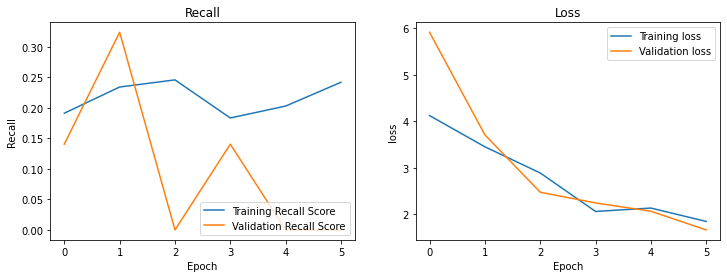

In [17]:
plot_accuracy_loss(efficientnet_hist)

The model has very low recall scores and does not seem to reduce the validation loss either.

#### DENSENET201

In [13]:
# Instantiate a densenet model
densenet = transfer_model(DenseNet201)
# compile model
densenet.compile(optimizer = "adam",
               loss = "categorical_crossentropy",
               metrics = ["Accuracy", "Precision", "Recall", keras.metrics.AUC(name = "auc")])

# fit model
densenet_hist = densenet.fit(X_train,
                          y_train,
                          steps_per_epoch = 8,
                          epochs = 30,
                          verbose = 1,
                          batch_size = 32,
                          validation_data = (X_val, y_val),callbacks=callback)

2023-01-15 09:46:31.434318: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 09:46:31.525067: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 09:46:31.526067: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 09:46:31.527743: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

74850304/74836368 [==============================] - 3s 0us/step


2023-01-15 09:46:41.186090: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2485080000 exceeds 10% of free system memory.
2023-01-15 09:46:43.890935: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2485080000 exceeds 10% of free system memory.
2023-01-15 09:46:45.876388: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2023-01-15 09:46:56.403744: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


8/8 [==============================] - 21s 702ms/step - loss: 7.3397 - Accuracy: 0.2695 - precision: 0.2785 - recall: 0.2578 - auc: 0.5457 - val_loss: 4.4483 - val_Accuracy: 0.5234 - val_precision: 0.5234 - val_recall: 0.5234 - val_auc: 0.6847
Epoch 2/30
8/8 [==============================] - 1s 185ms/step - loss: 3.5001 - Accuracy: 0.4180 - precision: 0.4177 - recall: 0.4062 - auc: 0.6353 - val_loss: 1.3890 - val_Accuracy: 0.4785 - val_precision: 0.4946 - val_recall: 0.4512 - val_auc: 0.7728
Epoch 3/30
8/8 [==============================] - 1s 181ms/step - loss: 2.2740 - Accuracy: 0.4961 - precision: 0.5000 - recall: 0.4648 - auc: 0.7251 - val_loss: 1.7391 - val_Accuracy: 0.4570 - val_precision: 0.4665 - val_recall: 0.4219 - val_auc: 0.7255
Epoch 4/30
8/8 [==============================] - 1s 189ms/step - loss: 1.4501 - Accuracy: 0.5742 - precision: 0.5785 - recall: 0.5469 - auc: 0.8065 - val_loss: 2.8189 - val_Accuracy: 0.3008 - val_precision: 0.3089 - val_recall: 0.2715 - val_auc: 0

In [14]:
evaluate_model(densenet)

train_results


2023-01-15 09:53:38.337685: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2485080000 exceeds 10% of free system memory.
2023-01-15 09:54:17.438625: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2485080000 exceeds 10% of free system memory.


288/288 [==============================] - 20s 60ms/step - loss: 1.6483 - Accuracy: 0.5629 - precision: 0.5811 - recall: 0.5405 - auc: 0.8009
validation_results
16/16 [==============================] - 1s 57ms/step - loss: 2.8189 - Accuracy: 0.3008 - precision: 0.3089 - recall: 0.2715 - auc: 0.5586
[2.8189456462860107, 0.30078125, 0.30888888239860535, 0.271484375, 0.5585575103759766]


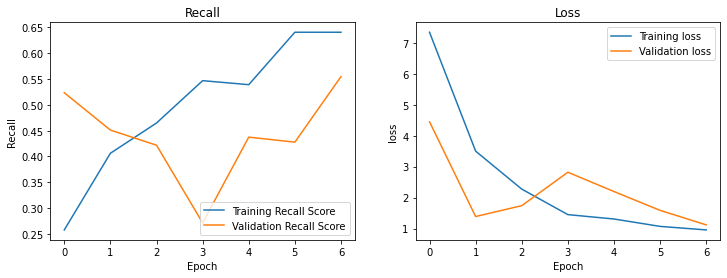

In [15]:
plot_accuracy_loss(densenet_hist)

#### EVALUATION

In [15]:
# evaluating the best model (model2) on the test data
model2.evaluate(X_test, y_test)

40/40 [==============================] - 1s 13ms/step - loss: 0.0751 - Accuracy: 0.9742 - precision: 0.9750 - recall: 0.9742 - auc: 0.9977


[0.0751226469874382,
 0.9742187261581421,
 0.9749804735183716,
 0.9742187261581421,
 0.9977346062660217]

The performance of our model on the test data is exemplary. It attained a recall score of 97.42% which surpassed our 95% metric of success. We will use the model for deployment.

In [17]:
# making predictions using the model
pred = model2.predict(X_test)
pred = np.argmax(pred, axis = 1)
y_test_new = np.argmax(y_test, axis = 1)

# print the classification report
print(classification_report(y_test_new, pred))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       187
           1       1.00      0.95      0.97        19
           2       0.97      0.99      0.98       632
           3       0.97      0.96      0.97       442

    accuracy                           0.97      1280
   macro avg       0.98      0.96      0.97      1280
weighted avg       0.97      0.97      0.97      1280



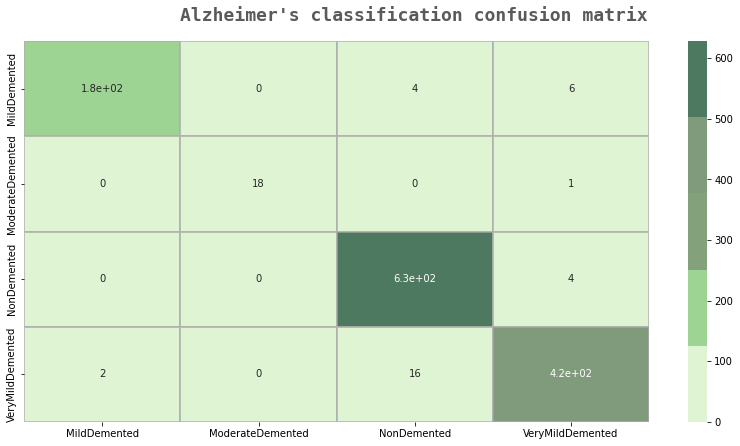

In [18]:
# colors for the confusion matrix
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']

# plotting the confusion matrix
fig, ax = plt.subplots(1, 1, figsize =  (14, 7))

sns.heatmap(confusion_matrix(y_test_new, pred), ax = ax, xticklabels = labels, yticklabels = labels, annot = True,
           cmap = colors_green[::-1], alpha = 0.7, linewidths = 2, linecolor = colors_dark[3])

fig.text(s = "Alzheimer's classification confusion matrix", size = 18, fontweight = "bold",
             fontname = "monospace", color = colors_dark[1], y = 0.92, x = 0.28, alpha = 0.8)

plt.show()

From the confusion matrix, 18 images were wrongly classified as verymilddemented,4 as nondemented,1 as moderate demented and 10 as milddemeted. Out of the 1280 images,only 33 images were wrongly classified;another proof that our model will work well with unseen data.

We will create a data frame from the results of our models.

In [3]:
column_names = ["Accuracy", "Precision", "Recall"]

row1 = [0.3242, 0.0, 0.0]
row2 = [0.8730, 0.8780, 0.8711]
row3 = [0.9824, 0.9863, 0.9824]
row4 = ['Null', 'Null', 0.7949]

df = pd.DataFrame([row1, row2, row3, row4], columns = column_names)

df.index = ["Base_model", "Simple_CNN", "Tuned_CNN", "RandomSearch_Model"]

df

,Accuracy,Precision,Recall
Base_model,0.3242,0.0,0.0000
Simple_CNN,0.873,0.878,0.8711
Tuned_CNN,0.9824,0.9863,0.9824
RandomSearch_Model,Null,Null,0.7949


In [4]:
# Transfer learning

column_names = ["Accuracy", "Precision", "Recall", "AUC"]

row1 = [0.3945, 0.4651, 0.0391, 0.7546]
row2 = [0.4316, 0.7619, 0.0625, 0.6922]
row3 = [0.0136, 0.0000, 0.0000, 0.2756]
row4 = [0.3008, 0.3089, 0.2715, 0.5586]

df2 = pd.DataFrame([row1, row2, row3, row4], columns = column_names)

df2.index = ["VGG16", "VGG19", "EfficientNetB0", "DenseNet201"]

df2

,Accuracy,Precision,Recall,AUC
VGG16,0.3945,0.4651,0.0391,0.7546
VGG19,0.4316,0.7619,0.0625,0.6922
EfficientNetB0,0.0136,0.0000,0.0000,0.2756
DenseNet201,0.3008,0.3089,0.2715,0.5586
